# Atividade 5
Realizar a segmentação dos pulmões através de uma imagem de radiografia, utilizando as filtro gaussiano e os operadores de passa alta para segmentar no pulmão.

### Importação das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

C:\Users\danil\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\danil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Funções utilizadas

In [294]:
# function for convolution operate
def convolution(wind, img, inv=True):

    wind = np.array(wind)
    wind_height, wind_width = wind.shape
    img_height, img_width = img.shape
    
    #calcule the zero-padding
    row_zero = int((wind_width-1)/2)
    col_zero = int((wind_height-1)/2)
    img = np.r_[np.zeros([row_zero, img_width]), img, np.zeros([row_zero, img_width])]
    img = np.c_[np.zeros([img_height + 2*row_zero, col_zero]), img, np.zeros([img_height + 2*row_zero, col_zero])]
    
    img_height, img_width = img.shape
    
    img2 = img.copy()
    if inv:
        for i in range(0, img_height-wind_height):
            for j in range(0, img_width-wind_width):
                inter = img[i:i+wind_height, j:j+wind_width]

                img2[i+row_zero, j+col_zero] = np.sum(inter*wind)
    else:
        print('inverso')
        for j in range(0, img_width-wind_width):
            for i in range(0, img_height-wind_height):
                inter = img[i:i+wind_height, j:j+wind_width]

                img2[i+row_zero, j+col_zero] = np.sum(inter*wind)
    
    # back to original dimension
    img2 = img2[row_zero:img_height-row_zero, col_zero:img_width-col_zero]
    return img2

# function for Sobel operator
def sobel(img):
    wind = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]
    img1 = convolution(wind, img)
    
    wind = [[1, 0, -1], [2, 0, -2], [1, 2, -1]]
    img2 = convolution(wind, img, False)
    
    return img1+img2

# function for laplacian filter
def laplacian(img, rot):
    if rot == 90:
        wind = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
    elif rot == 45:
        wind = [[1, 1, 1], [1, -8, 1], [1, 1, 1]]
    imgOut = convolution(wind, img)
    
    return imgOut

# function for laplacian constrast
def laplacianContrast(img, rot, c):
    img2 = laplacian(img, rot)
    imgOut = img + c*img2
    
    return imgOut

# threshold
def threshold(X, t):
    imgOut = np.zeros(X.shape)
    imgOut[np.where(X > t)] = 255
    
    return imgOut

#função para transformação logarítmica
def transLog(X):
    c = 255 / np.log(1 + np.max(X))
    log_image = c * (np.log(X + 1))
    
    log_image = np.array(log_image, dtype = np.uint8)
    return log_image

#função para filtro da média
def filtroMedia(X, size):
    imgOut = X.copy()

    for i in range(size, X.shape[0]-size):
        for j in range(size, X.shape[1]-size):
            subI = X[i-size:i+size+1, j-size:j+size+1]
            m = np.mean(subI)
            imgOut[i][j] = int(m)
    return imgOut

#função para correção gamma
def gamma(X, g):
    imgOut = np.array(255*(img / 255) ** g, dtype = 'uint8')
    
    return imgOut

# function for median filter
def medianFilter(X, size):
    imgOut = X.copy()
    
    for i in range(size, X.shape[0]-size):
        for j in range(size, X.shape[1]-size):
            subI = X[i-size:i+size+1, j-size:j+size+1]
            m = np.median(subI)
            imgOut[i][j] = int(m)
    return imgOut

def getCentroids(img):
    rows, cols = np.where(img[:,0:int(img.shape[1]/2)]==0)
    cr_l = int(np.mean(rows))
    cc_l = int(np.mean(cols))

    rows, cols = np.where(img[:,int(img.shape[1]/2):img.shape[1]]==0)
    cr_r = int(np.mean(rows)) 
    cc_r = int(np.mean(cols) + img.shape[1]/2)
    
    return cr_l, cc_l, cr_r, cc_r

# função de adjacência-4
def adj4(i, j, img, imgOut, newPixels):
    if img[i,j-1] == 1 and imgOut[i,j-1] == 0:
        imgOut[i,j-1] = 1
        newPixels = newPixels + 1
    if img[i,j+1] == 1 and imgOut[i,j+1] == 0:
        imgOut[i,j+1] = 1
        newPixels = newPixels + 1
    if img[i-1,j] == 1 and imgOut[i-1,j] == 0:
        imgOut[i-1,j] = 1
        newPixels = newPixels + 1
    if img[i+1,j] == 1 and imgOut[i+1,j] == 0:
        imgOut[i+1,j] = 1
        newPixels = newPixels + 1
    return newPixels

# detectar regiões de conexão
def connectRegions(img, x, y):
    img2 = np.zeros(np.shape(img))
    img2[np.where(img == 0)] = 1
    img2[np.where(img == 255)] = 0
    
    imgOut = np.zeros(np.shape(img))
    imgOut[x,y] = 1
    newPixels = 101
    newPixels2 = 0
    while newPixels>0:
        newPixels = 0
        newPixels2 = 0
        for i in range(1, np.shape(img)[0]-1):
            for j in range(1, np.shape(img)[1]-1):
                if imgOut[i,j] == 1:
                    newPixels = newPixels + adj4(i, j, img2, imgOut, newPixels2)
                    
        for i in range(np.shape(img)[0]-2, 1, -1):
            for j in range(1, np.shape(img)[1]-1):
                if imgOut[i,j] == 1:
                    newPixels = newPixels + adj4(i, j, img2, imgOut, newPixels2)
        #cv2.imshow('saida', imgOut)
        #cv2.waitKey(0)
        
    return imgOut

### Principal


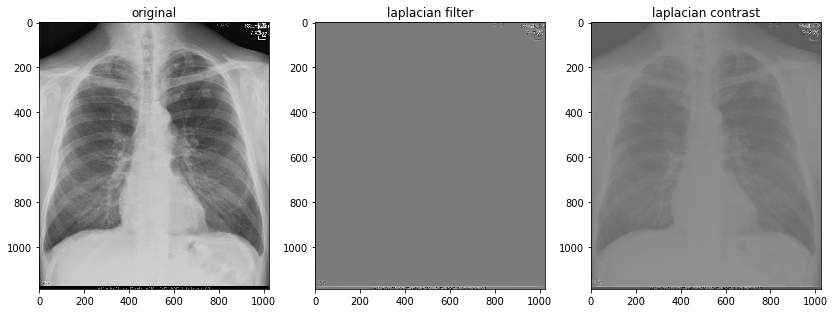

In [306]:
#leitura da imagem
img = cv2.imread('test images/radiografia.jpg', cv2.IMREAD_GRAYSCALE)

img2 = laplacian(img, 90)
img3 = laplacianContrast(img, 45, 1/2)

fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='original')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,3,2, title='laplacian filter')
plt.imshow(img2, cmap='gray')

fig.add_subplot(1,3,3, title='laplacian contrast')
plt.imshow(img3, cmap='gray')


plt.show()

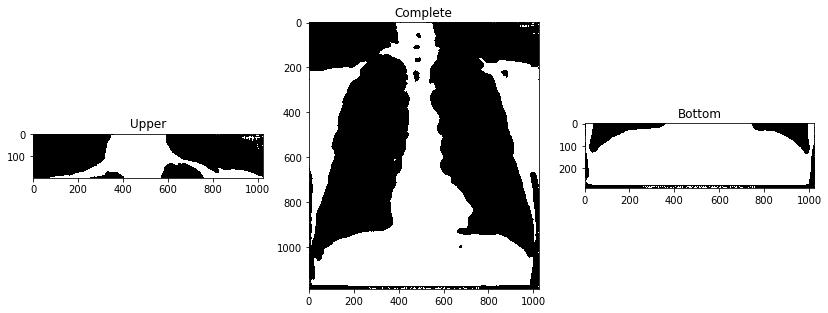

In [299]:
# mean filter
img4 = filtroMedia(img3, 5)

# local threshold
img_upper = threshold(img4[0:195, :], 136)
img_bottom = threshold(img4[900:img4.shape[0], :], 140)
imgC = threshold(img4, 165)

fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='Upper')
plt.imshow(img_upper, cmap='gray')

fig.add_subplot(1,3,2, title='Complete')
plt.imshow(imgC, cmap='gray')

fig.add_subplot(1,3,3, title='Bottom')
plt.imshow(img_bottom, cmap='gray')

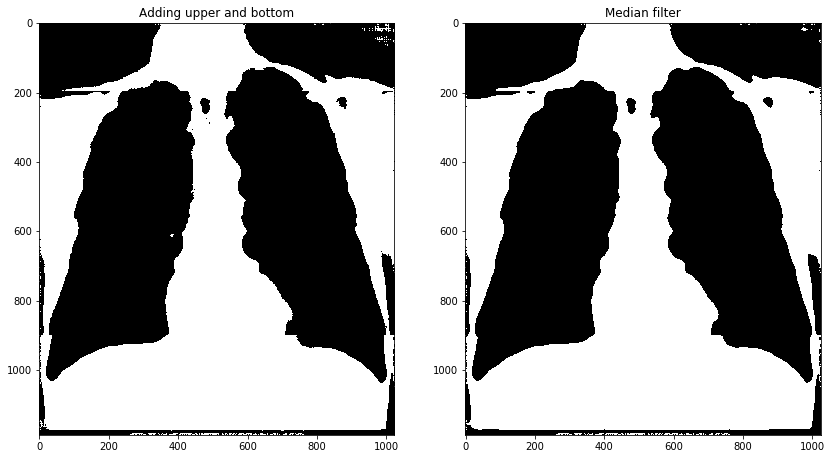

In [300]:
imgC[0:img_upper.shape[0],:] = img_upper
imgC[imgC.shape[0] - img_bottom.shape[0]:,:] = img_bottom

imgF = medianFilter(imgC, 5)

fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,2,1, title='Adding upper and bottom')
plt.imshow(imgC, cmap='gray')

fig.add_subplot(1,2,2, title='Median filter')
plt.imshow(imgF, cmap='gray')

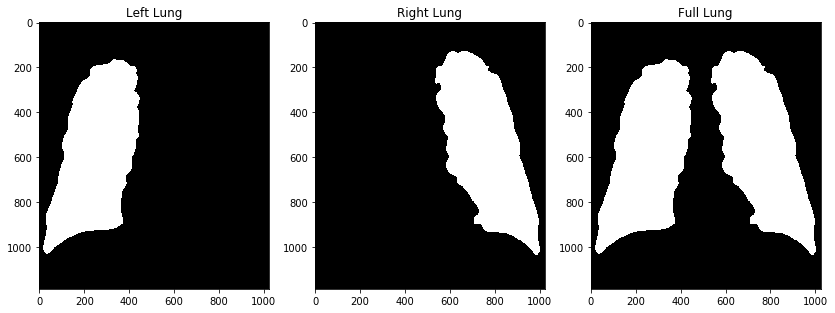

In [302]:
cr_l, cc_l, cr_r, cc_r = getCentroids(imgF)

# left and Right lung
lungL = connectRegions(imgF, cr_l, cc_l)
lungR = connectRegions(imgF, cr_r, cc_r)

# adding
Lung = lungL + lungR

fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='Left Lung')
plt.imshow(lungL, cmap='gray')

fig.add_subplot(1,3,2, title='Right Lung')
plt.imshow(lungR, cmap='gray')
                
fig.add_subplot(1,3,3, title='Full Lung')
plt.imshow(Lung, cmap='gray')

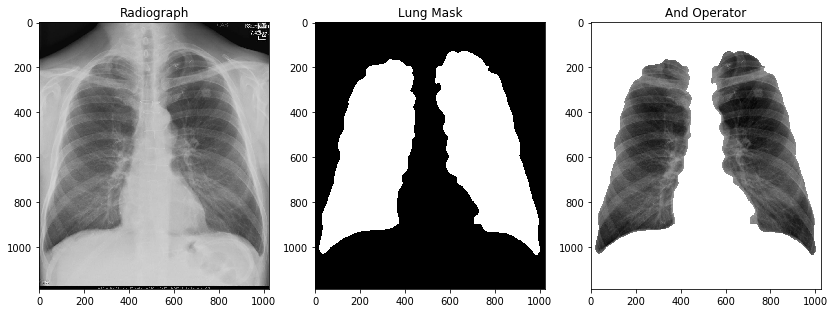

In [304]:
Lung = lungL + lungR

imgAnd = img.copy()
imgAnd[np.where(Lung == 0)] = 255

fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

fig.add_subplot(1,3,1, title='Radiograph')
plt.imshow(img, cmap='gray')

fig.add_subplot(1,3,2, title='Lung Mask')
plt.imshow(Lung, cmap='gray')
                
fig.add_subplot(1,3,3, title='And Operator')
plt.imshow(imgAnd, cmap='gray')